# Miniproyecto: *Representation Learning*

### EL7024 - Teoría de la Información: Fundamentos y Aplicaciones 
### Information and Decision Systems Group

En esta clase se revisarán los fundamentos y ejemplos experimentales de [*Autoencoders* Variacionales](https://arxiv.org/abs/1312.6114) (Kingma & Welling, 2014) y del [Método del *Information Bottleneck*](https://arxiv.org/abs/physics/0004057) (Tishby et al., 1999)

## Preliminares

In [ ]:
# %tensorflow_version 1.x
# %load_ext tensorboard

%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from copy import deepcopy
from matplotlib import cm
from mpl_toolkits import mplot3d
from sklearn.datasets import fetch_openml
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader, Subset

print('Pytorch version:', torch.__version__)

use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print('Device:', device)

Pytorch version: 1.11.0+cu113
Device: cuda:0


In [ ]:
!nvidia-smi

Thu May 26 20:32:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    12W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### MNIST *Dataset*

In [ ]:
#  Batch Sizes
train_batch_size = 100
val_batch_size = 100

# Train-Val Split
train_dataset_mnist = datasets.MNIST(root='./', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()]))

val_dataset_mnist = datasets.MNIST(root='./', train=False, 
                        transform=transforms.Compose([
                            transforms.ToTensor()]))

train_dataset_mnist_8bit = datasets.MNIST(root='./', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: (x * 255).to(torch.uint8)),
                           transforms.Lambda(lambda x: x.to(torch.float))]))

val_dataset_mnist_8bit = datasets.MNIST(root='./', train=False, 
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Lambda(lambda x: (x * 255).to(torch.uint8)),
                            transforms.Lambda(lambda x: x.to(torch.float))]))

# DataLoaders
train_loader_mnist = torch.utils.data.DataLoader(train_dataset_mnist,
                                           batch_size = train_batch_size)
val_loader_mnist = torch.utils.data.DataLoader(val_dataset_mnist,
                                          batch_size = val_batch_size)

train_loader_mnist_8bit = torch.utils.data.DataLoader(train_dataset_mnist_8bit,
                                           batch_size = train_batch_size)
val_loader_mnist_8bit = torch.utils.data.DataLoader(val_dataset_mnist_8bit,
                                          batch_size = val_batch_size)

Label : 1


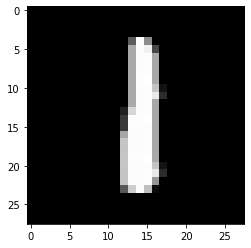

Max  value: 1.0, Min value: 0.0
Label : 3


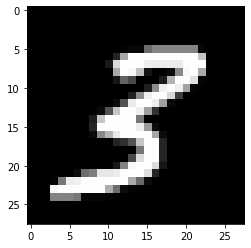

Max  value: 255.0, Min value: 0.0


In [ ]:
loader = val_loader_mnist
index = np.random.randint(len(loader.dataset))
img = loader.dataset[index][0].numpy()[0]
print('Label : {}'.format(loader.dataset[index][1]))
plt.figure()
plt.imshow(img,cmap=cm.gray)
plt.show()
print('Max  value: {}, Min value: {}'.format(np.amax(img), np.amin(img)))

loader = val_loader_mnist_8bit
index = np.random.randint(len(loader.dataset))
img = loader.dataset[index][0].numpy()[0]
print('Label : {}'.format(loader.dataset[index][1]))
plt.figure()
plt.imshow(img,cmap=cm.gray)
plt.show()
print('Max  value: {}, Min value: {}'.format(np.amax(img), np.amin(img)))

## 1.- Inferencia Variacional

Es un método para aproximar distribuciones de probabilidad difíciles de tratar, especialmente cuando solo se tienen muestras de la distribución. Esto se hace por medio de optimización sobre una familia de distribuciones candidatas.

### 1.1.- Motivación

Desde una perspectiva Bayesiana, considérense las variables aleatorias $\mathbf{X} \in \mathcal{X}$ y $\mathbf{Z} \in \mathcal{Z}$, cuya distribución conjunta está dada por:

\begin{equation}
p(\mathbf{x}, \mathbf{z}) = p(\mathbf{x}|\mathbf{z})p(\mathbf{z}),
\end{equation}

donde $p(\mathbf{z})$ se percibe como un *prior* sobre la distribución de la variable **latente**, relacionada estadísticamente con las **observaciones** por medio de la verosimilitud $p(\mathbf{x}|\mathbf{z})$.

Un modelo de inferencia/estimación Bayesiano apunta a obtener la distribución de $\mathbf{Z}$ condicionada a las observaciones, es decir la *posterior* $p(\mathbf{z}|\mathbf{x})$.

El cálculo de cada una de estas distribuciones a partir de datos suele ser complicado, por lo que típicamente se recurre a mecanísmos de aproximación entre ellos la **Inferencia Variacional**.

### 1.2.- Planteamiento del Problema

Para el caso (más usual) de estimar la *posterior* $p(\mathbf{z}|\mathbf{x})$ a partir de datos o muestras de la variable $\mathbf{x}$ se recurre a escribir:

\begin{equation}
p(\mathbf{z}|\mathbf{x}) = \frac{p(\mathbf{x},\mathbf{z})}{p(\mathbf{x})}, \hspace{5mm} p(\mathbf{x}) = \int_{\mathcal{Z}}p(\mathbf{x},\mathbf{z})d\mathbf{z}
\end{equation}

No obstante, dadas las dificultades del cálculo directo de esta distribución se plantea su resolución (aproximada) como un problema de optimización sobre una familia de distribuciones $\mathcal{Q}$. En este sentido, se busca una distrubución $q^{*}(\mathbf{z}) \in \mathcal{Q}$ tal que:

\begin{equation}
q^{*}(\mathbf{z}) \approx p(\mathbf{z}|\mathbf{x})
\end{equation}

Resta definir el funcional sobre el cual se realiza el proceso de optimización. Naturalmente, aparece en este punto el concepto de **divergencia**; por lo que típicamente el problema se plantea finalmente como:

\begin{equation}
q^{*}(\mathbf{z}) = \underset{q(\mathbf{z}) \in \mathcal{Q}}{\operatorname{arg min}} KL(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x})) \tag{1}
\end{equation}

En particular, resulta más práctico caracterizar a su vez la familia de distribuciones $\mathcal{Q}$ por medio de un espacio paramétrico $\Theta$. Esto quiere decir que $\Theta$ induce una familia $\mathcal{Q}$ de distribuciones paramétricas sobre $\mathbf{Z}$, denotadas por $q_{\theta}(\mathbf{z})$. Luego, el problema de optimización anterior se redefine por medio de dicho conjunto de **parámetros** como:

\begin{equation}
q_{\theta^{*}}(\mathbf{z}) = \underset{q_{\theta}(\mathbf{z}),\hspace{1mm} \theta \in \Theta}{\operatorname{arg min}} KL(q_{\theta}(\mathbf{z})||p(\mathbf{z}|\mathbf{x})) \tag{2}
\end{equation}

### 1.3.- La *Evidence Lower Bound* (ELBO)

Lamentablemente, aún planteado de esta forma el problema requiere calcular la **evidencia** $p(\mathbf{x})$, por lo que se define un funcional "equivalente" a la divergencia de Kullback-Leibler, denominado *Evidence Lower Bound* o ELBO:

\begin{equation}
\begin{split}
ELBO(q) &= \mathbb{E}_{\mathbf{Z} \sim q(\mathbf{z})}\{\log{p(\mathbf{x},\mathbf{z})}\} - \mathbb{E}_{\mathbf{Z} \sim q(\mathbf{z})}\{\log{q(\mathbf{z})}\} \\
&= \mathbb{E}_{\mathbf{Z} \sim q(\mathbf{z})}\{\log{p(\mathbf{x}|\mathbf{z})}\} - KL(q(\mathbf{z})||p(\mathbf{z}))
\end{split} \tag{3}
\end{equation}

### 1.4.- Síntesis

Lo importante del planteamiento detrás de **Inferencia Variacional** es que permite calcular (en forma aproximada) una distribución de interés sobre una variable aleatoria por medio de la optimización sobre los parámetros $\theta \in \Theta$, introduciendo así una densidad "auxiliar" $q_{\theta}(\cdot)$ sobre dicha variable aleatoria.

## 2.- *Autoencoders* Variacionales

### 2.1.- *Autoencoders*

Los Autoencoders son una subcategoría de las redes neuronales, orientadas a problemas y/o etapas no supervisadas de aprendizaje. El objetivo es que la red aprenda a generar Representaciones Latentes de un fenómeno $X$ a partir de los datos de entrada $\{x_{i}\}_{i=1}^{N}$, y reconstruir estos últimos a partir del código latente.

Entre las utilidades que presentan los autoencoders se encuentran:

*   Reducción de Dimensionalidad
*   Representación Eficiente de Datos
*   Obtención de Características y *Pretraining* de Redes
*   *Denoising*
*   Modelos Generativos

Estructuralmente los autoencoders se componen de $2$ partes:

*   *Encoder*: Transforma las entradas al Espacio Latente. A veces se le denomina *Recognition Model* o *Inference Model*.
*   *Decoder*: Realiza el proceso inverso al *encoder*. Representa la parte Generativa del modelo.

      ![texto alternativo](https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/Autoencoder_structure.png/350px-Autoencoder_structure.png)

Este tipo de modelo se entrena por medio de alguna Función de Pérdida, denominada *Reconstruction Loss*. Cuando se incorporan términos de regularización sobre el Espacio Latente se suele denominarlos por *Latent Loss*.

Más concretamente, denotando el *encoder* por la función $\Phi$ y el *decoder* por la función $\Psi$ se tiene que:

\begin{equation}
  \begin{split}
    &\Phi: \mathcal{X} \to \mathcal{Z} \\
    &\Psi: \mathcal{Z} \to \mathcal{X},
  \end{split}
\end{equation}

con lo cual, la salida de la red corresponde a una **reconstrucción** de la entrada $\mathbf{x}$, $\mathbf{x}'$:

\begin{equation}
  \mathbf{x}' = \Psi(\mathbf{z}) =  \Psi\circ\Phi(\mathbf{x})
\end{equation}

Típicamente, se utiliza como *Reconstruction Loss* el error cuadrático entre $\mathbf{x}$ y $\mathbf{x}'$, por lo que el modelo completo del autoencoder se define como:

\begin{equation}
  \Phi, \Psi = \underset{\Phi, \Psi}{\operatorname{arg min}}||\mathbf{x} - \Psi\circ\Phi(\mathbf{x})||^{2}
\end{equation}

Un *autoencoder* variacional sigue el mismo principio expuesto anteriormente, con la diferencia de que se desea que tanto el *encoder* como el *decoder* sean probabilísticos (o que representen alguna función de probabilidad), en el sentido de que cada uno induce un mapeo estocástico desde el espacio de entradas al espacio latente, y viceversa, permitiendo hacer inferencia en forma eficiente.

### 2.2.- *Autoencoders* Variacionales

Volviendo al punto anterior, es evidente que un *autoencoder* tradicional es entrenado para capturar en su *encoder* una aproximación degenerada de $p(\mathbf{z}|\mathbf{x})$ en el sentido que, dada una muestra $\mathcal{x}_{i}$:

\begin{equation}
P(\mathbf{Z} = \Phi(\mathcal{x}_{i})|\mathbf{X} = \mathcal{x}_{i}) = 1
\end{equation}

Es decir, no es posible hacer inferencia desde una perspectiva estadística. En este sentido, no es posible realizar una caracterización del siguiente **modelo gráfico dirigido** (el cual es justamente el estudiado en la sección de Inferencia Variacional):

>>>>>>>>![texto alternativo](https://jaan.io/images/graphical-model-variational-autoencoder.png)


En base a un argumento similar, un *autoencoder* tradicional posee en su etapa de *decoder* un modelo generativo considerablemente pobre al ser determinístico, condicionado exclusivamente a la entrada $\mathbf{x}$.

\\

La pregunta clave es entonces: ¿cómo podemos hacer inferencia sobre $p(\mathbf{z}|\mathbf{x})$ y obtener con ello un modelo generativo más expresivo?

#### 2.2.1.- Fundamentos Teóricos

##### Planteamiento del Problema

Consideremos el dataset $\mathcal{X} = \left\{\mathbf{x}^{(i)}\right\}_{i=1}^{N}$, formado por muestras *i.i.d.* del vector aleatorio $K$-dimensional $\mathbf{X}$. Tal como revisamos en la sección de Inferencia Variacional, se asume que el proceso generativo de $\mathbf{X}$ se rige según la variable (aleatoria) latente $J$-dimensional $\mathbf{Z}$ y es parametrizado por $\theta^{*}$:

\begin{equation}
  \mathbf{X}  \sim p_{\theta^{*}}(\mathbf{x}|\mathbf{z}), \hspace{5mm} \mathbf{Z} \sim p_{\theta^{*}}(\mathbf{z}),
\end{equation}

donde $p_{\theta^{*}}(\mathbf{z})$ consiste en **alguna** distribución *a priori*.

En términos prácticos, tanto los valores $\mathbf{z}$ como $\theta^{*}$ son desconocidos

> **Nota**: $\mathbf{Z}$ gobierna el comportamiento estadístico de $\mathbf{X}$ (dado que es una **variable latente**), mientras que $\theta^{*}$ determina la forma en que esto ocurre, es decir determina el efecto de $\mathbf{z}$ sobre $\mathbf{x}$ por medio de $p_{\theta^{*}}(\mathbf{x}|\mathbf{z})$.

Por lo tanto, en un problema de inferencia "clásico" se apunta a determinar el valor de $\mathbf{z}$ para distintos puntos en el dominio de $\mathbf{X}$, para lo cual se debe a su vez tener un valor (aproximado) de los parámetros $\theta^{*}$.

Asumiendo que $p_{\theta^{*}}(\mathbf{x}|\mathbf{z})$ y $p_{\theta^{*}}(\mathbf{z})$ viven en una familia de distribuciones paramétricas $\mathcal{Q}$ determinada por $\theta^{*} \in \Theta$, es posible emplear Inferencia Variacional para aproximarlas.

Para abordar el problema se introduce un ***Recognition Model*** (o ***Encoder* probabilístico**) $q_{\phi}(\mathbf{z}|\mathbf{x})$, el cual es una aproximación de la distribución posterior $p_{\theta^{*}}(\mathbf{z}|\mathbf{x})$. Los parámetros $\phi$ son aprendidos simultáneamente con los del **Modelo Generativo** (denominado ***Decoder* probabilístico**) $p_{\theta}(\mathbf{x}|\mathbf{z})$.

##### Tratamiento del Problema

El objetivo se plantea en forma similar a como se propone en Inferencia Variacional. En este caso se propone minimizar la divergencia entre $q_{\phi}(\mathbf{z}|\color{red}{\mathbf{x}})$ y $p_{\theta^{*}}(\mathbf{z}|\mathbf{x})$. De esta forma, se rescata una cota inferior para la Evidencia, tal como en Inferencia Variacional:

\begin{equation}
  \log p_{\theta^{*}}(\mathbf{x}) \geq \mathbb{E}_{\mathbf{Z} \sim q_{\phi}(\mathbf{z}|\mathbf{x})}\left\{\log p_{\theta^{*}}(\mathbf{x}|\mathbf{z})\right\} - KL\left(q_{\phi}(\mathbf{z}|\mathbf{x})||p_{\theta^{*}}(\mathbf{z})\right)
\end{equation}

No obstante, tanto $p_{\theta^{*}}(\mathbf{x}|\mathbf{z})$ como $p_{\theta^{*}}(\mathbf{z})$ son desconocidos. Si bien siguiendo el enfoque Bayesiano de Inferencia Variacional en este punto se emplea un *prior* $p_{\theta}(\mathbf{z})$ (más precisamente $p(\mathbf{z})$) aún es insuficiente para abordar este objetivo. La razón de esto es que no se asume conocimiento preciso sobre el Modelo Generativo $p_{\theta^{*}}(\mathbf{x}|\mathbf{z})$, sino que se busca aproximarlo por medio de $p_{\theta}(\mathbf{x}|\mathbf{z}) \approx p_{\theta^{*}}(\mathbf{x}|\mathbf{z})$.

Reemplazando, el funcional a optimizar por cada muestra $\mathbf{x}^{(i)}$ está dado por

\begin{equation}
  \mathcal{L}(\phi, \theta, \mathbf{x}^{(i)}) = \mathbb{E}_{\mathbf{Z} \sim q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)})}\left\{\log p_{\theta}(\mathbf{x}^{(i)}|\mathbf{z})\right\} - KL\left(q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)})||p_{\theta}(\mathbf{z})\right) \tag{4}
\end{equation}

> **Nota**: El supuesto de que $p_{\theta}(\mathbf{x}|\mathbf{z}) \approx p_{\theta^{*}}(\mathbf{x}|\mathbf{z})$ es bastante fuerte puesto que nada más allá del propio proceso de optimización ofrece alguna garantía de que esto sea así efectivamente.

Usualmente, al tratarse de esperanzas, estos términos son difíciles de tratar en forma eficiente, más aún si no se tiene acceso en forma directa a $p_{\theta}(\mathbf{x^{(i)}}|z)$ ni a $q_{\phi}(\mathbf{z}|\mathbf{x^{(i)}})$ ni tampoco a muestras de $\mathbf{Z}$ que permitan alguna estimación empírica de las esperanzas.

No obstante, bajo supuestos sobre la "forma" de estas distribuciones es posible:

* Calcular en forma cerrada la verosimilitud de $\mathbf{x^{(i)}}$.
* Muestrear la variable latente (en forma condicional a $\mathbf{x^{(i)}}$) gracias al  ***Reparametrization Trick***.

##### *Reparametrization Trick*

El *Reparametrization Trick* cosiste en reparametrizar la variable aleatoria latente $\mathbf{Z}$ como una función determinística de dos variables aleatorias: la variable $\mathbf{X}$ y un ruido aleatorio $\epsilon$ con recorrido en $\xi$. Esta función $g_{\phi}(\mathbf{x},\epsilon)$ es diferenciable respecto a los parámetros $\phi$ del *encoder*, con lo cual es posible tanto muestrear (a partir de muestrear $\mathbf{X}$ y $\epsilon$) y propagar los gradientes a través de la red para actualizar dichos parámetros. Formalmente, la función $g_{\phi}(\mathbf{x},\epsilon)$ es tal que:

\begin{equation}
  \begin{split}
    g_{\phi} : &\mathcal{X} \times \xi \to \mathcal{Z}\\
               &\mathbf{x}, \epsilon \to \mathbf{z} = g_{\phi}(\mathbf{x},\epsilon), \hspace{5mm} \epsilon \sim p(\epsilon)
  \end{split}
\end{equation}

y se satisface en consecuencia que $\mathbf{z} = g_{\phi}(\mathbf{x},\epsilon) \sim q_{\phi}(\mathbf{z}|\mathbf{x})$.

Naturalmente, la elección de $g_{\phi}$ y $p(\epsilon)$ condiciona la forma de $q_{\phi}(\mathbf{z}|\mathbf{x})$. Para variables aleatorias contínuas, pensemos en una distribución Gaussiana. Si $q_{\phi}(\mathbf{z}|\mathbf{x})$ es Gaussiana su media y su varianza son (en principio) funciones de $\mathbf{x}$, es decir

\begin{equation}
  q_{\phi}(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mathbf{z};\mu_{\mathbf{z}}(\mathbf{x}), \Sigma_{\mathbf{z}}(\mathbf{x}))
\end{equation}

y si, en forma más "restrictiva", $\mathbf{z}$ es un vector aleatorio con componentes descorrelacionadas:

\begin{equation}
  q_{\phi}(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mathbf{z};\mu_{\mathbf{z}}(\mathbf{x}),\sigma_{\mathbf{z}}^{2}(\mathbf{x})I)
\end{equation}

Eligiendo entonces

\begin{equation}
  g_{\phi}(\mathbf{x},\epsilon) = \mu_{\mathbf{z}}(\mathbf{x}) + \sigma_{\mathbf{z}}(\mathbf{x}) \odot \epsilon, \hspace{5mm} \epsilon \sim \mathcal{N}(\epsilon,0,I)
\end{equation}

se satisface la condición deseada. Notar que la operación $\odot$ denota el producto punto a punto entre dos vectores.

En forma más conceptual se puede decir que lo que hace el *Reparametrization Trick* es escalar y trasladar un ruido $\epsilon$ de modo que estadísticamente se comporte como una variable aleatoria Gaussiana de parámetros $\mu_{\mathbf{z}}(\mathbf{x}), \Sigma_{\mathbf{z}}(\mathbf{x})$.

###### Demostración

Según el *Reparametrization Trick* se tiene que

\begin{equation}
  \begin{split}
    q_{\phi}(\mathbf{z}|\mathbf{x})d\mathbf{z} &= q_{\phi}(\mathbf{z}|\mathbf{x})\prod_{j=1}^{J}dz_{j} \\
    &= p(\epsilon)\prod_{j=1}^{J}d\epsilon_{j} \\
    &= p(\epsilon)d\epsilon
  \end{split}
\end{equation}

Luego, para la media de $\mathbf{Z}$

\begin{equation}
  \begin{split}
    \mathbb{E}_{\mathbf{Z} \sim q_{\phi}(\mathbf{z}|\mathbf{x})}\left\{\mathbf{z}\right\} &= \int_{\mathcal{Z}}\mathbf{z}q_{\phi}(\mathbf{z}|\mathbf{x})d\mathbf{z} \\
    &= \int_{\mathbb{R}^{J}}g_{\phi}(\mathbf{x},\epsilon)p(\epsilon)d\epsilon \\
    &= \int_{\mathbb{R}^{J}}(\mu_{\mathbf{z}}(\mathbf{x}) + \sigma_{\mathbf{z}}(\mathbf{x}) \odot \epsilon)p(\epsilon)d\epsilon \\
    &= \mu_{\mathbf{z}}(\mathbf{x}) + \sigma_{\mathbf{z}}(\mathbf{x}) \odot \int_{\mathbb{R}^{J}}\epsilon p(\epsilon)d\epsilon \\
    &= \mu_{\mathbf{z}}(\mathbf{x})
  \end{split}
\end{equation}

y para su varianza

\begin{equation}
  \begin{split}
    Var_{\mathbf{Z} \sim q_{\phi}(\mathbf{z}|\mathbf{x})}(\mathbf{z}) &= \mathbb{E}_{\mathbf{Z} \sim q_{\phi}(\mathbf{z}|\mathbf{x})}\left\{(\mathbf{z} - \mu_{\mathbf{z}}(\mathbf{x}))^{2}\right\} \\
    &= \int_{\mathcal{Z}}(\mathbf{z} - \mu_{\mathbf{z}}(\mathbf{x}))^{2}q_{\phi}(\mathbf{z}|\mathbf{x})d\mathbf{z} \\
    &= \int_{\mathbb{R}^{J}}(g_{\phi}(\mathbf{x},\epsilon) - \mu_{\mathbf{z}}(\mathbf{x}))^{2}p(\epsilon)d\epsilon \\
    &= \int_{\mathbb{R}^{J}}(\mu_{\mathbf{z}}(\mathbf{x}) + \sigma_{\mathbf{z}}(\mathbf{x}) \odot \epsilon - \mu_{\mathbf{z}}(\mathbf{x}))^{2}p(\epsilon)d\epsilon \\
    &= \int_{\mathbb{R}^{J}}\sigma_{\mathbf{z}}^{2}(\mathbf{x}) \odot \epsilon^{2}p(\epsilon)d\epsilon \\
    &= \sigma_{\mathbf{z}}^{2}(\mathbf{x}) \odot \int_{\mathbb{R}^{J}}\epsilon^{2}p(\epsilon)d\epsilon \\
    &= \sigma_{\mathbf{z}}^{2}(\mathbf{x})I
  \end{split}
\end{equation}

Finalmente, como una distribución Gaussiana está caracterizada completamente por su media y su varianza se concluye que $q_{\phi}(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mathbf{z};\mu_{\mathbf{z}}(\mathbf{x}),\sigma_{\mathbf{z}}^{2}(\mathbf{x})I)$

###### Y luego...

Bajo este tipo de supuestos es posible muestrear la variable aleatoria latente para cada punto en $\mathcal{X}$, es decir (y en particular) $\forall \mathbf{x}^{(i)} \in \left\{\mathbf{x}^{(i)}\right\}_{i=1}^{N}$ se puede muestrear un conjunto $\left\{\mathbf{z}^{(i,l)}:\mathbf{z}^{(i,l)} \sim q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)})\right\}_{l=1}^{L}$, con lo cual es posible aproximar dicha distribución condicional en forma empírica según

\begin{equation}
  q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)}) \approx \frac{1}{L}\sum_{l=1}^{L}\delta_{\mathbf{z}^{(i,l)}}(\mathbf{z}) \tag{5}
\end{equation}

y por ende

\begin{equation}
  \begin{split}
    \mathbb{E}_{\mathbf{Z} \sim q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)})}\left\{\log p_{\theta}(\mathbf{x}^{(i)}|\mathbf{z})\right\} &= \int_{\mathcal{Z}}\log p_{\theta}(\mathbf{x}^{(i)}|\mathbf{z})q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)})d\mathbf{z} \\
    &\approx \int_{\mathcal{Z}}\log p_{\theta}(\mathbf{x}^{(i)}|\mathbf{z}) \frac{1}{L}\sum_{l=1}^{L}\delta_{\mathbf{z}^{(i,l)}}(\mathbf{z})d\mathbf{z} \\
    &= \frac{1}{L}\sum_{l=1}^{L}\log p_{\theta}(\mathbf{x}^{(i)}|\mathbf{z}^{(i,l)})
  \end{split}
\end{equation}

Luego, esta esperanza aproximada se puede reemplazar en la expresión para el funcional $\mathcal{L}(\phi,\theta,\mathbf{x}^{(i)})$ de la ecuación $(4)$ que acota la *log-likelihood* marginal del punto $\mathbf{x}^{(i)}$:

\begin{equation}
  \begin{split}
    \log p_{\theta^{*}}(\mathbf{x}^{(i)}) &\geq \mathcal{L}(\phi,\theta,\mathbf{x}^{(i)}) \\
    &= \frac{1}{L}\sum_{l=1}^{L}\log p_{\theta}(\mathbf{x}^{(i)}|\mathbf{z}^{(i,l)}) - KL\left(q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)})||p_{\theta}(\mathbf{z})\right)
  \end{split} \tag{6}
\end{equation}

El hecho de haber utilizado el *Reparametrization Trick* (o más bien el hecho de asumir un modelo sobre $\mathbf{Z}$) nos permite, además, tratar en forma cerrada la divergencia que aparece en el segundo termino de este funcional, dado un *prior* $p_{\theta}(\mathbf{z})$. Esto es así pues en el proceso se asumió la forma de la distribución $q_{\phi}(\mathbf{z}|\mathbf{x})$

\begin{equation}
  \begin{split}
    KL\left(q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)})||p_{\theta}(\mathbf{z})\right) &= \int_{\mathcal{Z}}q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)}) \log \frac{q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)})}{p_{\theta}(\mathbf{z})}d\mathbf{z} \\
    &= \int_{\mathcal{Z}}q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)})\log q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)})d\mathbf{z} - \int_{\mathcal{Z}}q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)})\log p_{\theta}(\mathbf{z})d\mathbf{z} \\
    &\triangleq I_{1} - I_{2}
  \end{split} \tag{7}
\end{equation}

Resolviendo primeramente para la integral $I_{1}$:

> \begin{equation}
    \begin{split}
      I_{1} &= \int_{\mathcal{Z}}q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)}) \log q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)})d\mathbf{z} \\
      &= \int_{\mathbb{R}^{J}}q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)})\log \left((2\pi)^{\frac{-J}{2}} \cdot |\Sigma_{\mathbf{z}}(\mathbf{x}^{(i)})|^{\frac{-1}{2}} \cdot \exp\left(-\frac{1}{2}(\mathbf{z} - \mu_{\mathbf{z}}(\mathbf{x}^{(i)}))^{\intercal}\Sigma_{\mathbf{z}}^{-1}(\mathbf{x}^{(i)})(\mathbf{z} - \mu_{\mathbf{z}}(\mathbf{x}^{(i)}))\right)\right)d\mathbf{z}
    \end{split}
  \end{equation}

> Si, como se dijo anteriormente, se considera que $\Sigma_{\mathbf{z}}(\mathbf{x}^{(i)})$ es una matriz diagonal es posible reducir esta expresión fácilmente:

> \begin{equation}
    \begin{split}
      I_{1} &= \int_{\mathbb{R}^{J}}q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)})\left[\log \left((2\pi)^{\frac{-J}{2}} \cdot \left(\prod_{j=1}^{J}\sigma_{z_{j}}^{2}(\mathbf{x}^{(i)})\right)^{\frac{-1}{2}}\right) + -\frac{1}{2}\sum_{j=1}^{J}\frac{(z_{j} - \mu_{z_{j}}(\mathbf{x}^{(i)}))^{2}}{\sigma_{z_{j}}^{2}(\mathbf{x}^{(i)})}\right]d\mathbf{z} \\
      &= \left(-\frac{J}{2}\log 2\pi + -\frac{1}{2}\sum_{j=1}^{J}\log \sigma_{z_{j}}^{2}(\mathbf{x}^{(i)})\right)\int_{\mathbb{R}^{J}}q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)})d\mathbf{z} + -\frac{1}{2}\int_{\mathbb{R}^{J}}q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)})\sum_{j=1}^{J}\frac{(z_{j} - \mu_{z_{j}}(\mathbf{x}^{(i)}))^{2}}{\sigma_{z_{j}}^{2}(\mathbf{x}^{(i)})}d\mathbf{z} \\
      &= -\frac{J}{2}\log 2\pi + -\frac{1}{2}\sum_{j=1}^{J}\log \sigma_{z_{j}}^{2}(\mathbf{x}^{(i)}) + -\frac{1}{2}\sum_{j=1}^{J}\frac{\int_{\mathbb{R}}q_{\phi}(z_{j}|\mathbf{x}^{(i)})(z_{j} - \mu_{z_{j}}(\mathbf{x}^{(i)}))^{2}dz_{j}}{\sigma_{z_{j}}^{2}(\mathbf{x}^{(i)})} \\
      &= -\frac{J}{2}\log 2\pi + -\frac{1}{2}\sum_{j=1}^{J}\log \sigma_{z_{j}}^{2}(\mathbf{x}^{(i)}) + -\frac{1}{2}\sum_{j=1}^{J}\frac{\sigma_{z_{j}}^{2}(\mathbf{x}^{(i)})}{\sigma_{z_{j}}^{2}(\mathbf{x}^{(i)})} \\
      &= -\frac{J}{2}\log 2\pi + -\frac{1}{2}\sum_{j=1}^{J}1 + \log \sigma_{z_{j}}^{2}(\mathbf{x}^{(i)})
    \end{split} \tag{8}
  \end{equation}

>> **Nota**: Para el caso más general puede ser útil este [enlace](https://sgfin.github.io/2017/03/11/Deriving-the-information-entropy-of-the-multivariate-gaussian/).

Como bien se dijo anteriormente, para resolver analíticamente esta divergencia es necesario introducir un *prior* $p_{\theta}(\mathbf{z})$. Si se elige $p_{\theta}(\mathbf{z}) = \mathcal{N}(\mathbf{z}; 0, I)$, la integral $I_{2}$ se resuelve como:

> \begin{equation}
    \begin{split}
      I_{2} &= \int_{\mathcal{Z}}q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)}) \log p_{\theta}(\mathbf{z}) d\mathbf{z} \\
      &= \int_{\mathbb{R}^{J}}q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)}) \log \left((2\pi)^{\frac{-J}{2}} \cdot |I|^{\frac{-1}{2}} \cdot \exp \left(-\frac{1}{2}\mathbf{z}^{\intercal}I^{-1}\mathbf{z}\right)\right) d\mathbf{z} \\
      &= \int_{\mathbb{R}^{J}}q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)}) \log \left((2\pi)^{\frac{-J}{2}} \cdot \prod_{j=1}^{J}1 \cdot \exp \left(-\frac{1}{2}\mathbf{z}^{\intercal}\mathbf{z}\right)\right) d\mathbf{z} \\
      &= \int_{\mathbb{R}^{J}}q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)}) \left[-\frac{J}{2}\log 2\pi + -\frac{1}{2}\sum_{j=1}^{J}\log 1 + -\frac{1}{2}\mathbf{z}^{\intercal}\mathbf{z}\right] d\mathbf{z} \\
      &= -\frac{J}{2}\log 2\pi + -\frac{1}{2}\int_{\mathbb{R}^{J}}q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)})\sum_{j=1}^{J}z_{j}^{2} d\mathbf{z} \\
      &= -\frac{J}{2}\log 2\pi + -\frac{1}{2}\sum_{j=1}^{J}\int_{\mathbb{R}}z_{j}^{2}q_{\phi}(z_{j}|\mathbf{x}^{(i)}) dz_{j} \\
      &= -\frac{J}{2}\log 2\pi + -\frac{1}{2}\sum_{j=1}^{J}\mu_{z_{j}}^{2}(\mathbf{x}^{(i)}) + \sigma_{z_{j}}^{2}(\mathbf{x}^{(i)}) 
    \end{split} \tag{9}
  \end{equation}

Finalmente, reemplazamos ambas integrales ($(8)$ y $(9)$) en la expresión de la ecuación $(7)$, con lo cual

\begin{equation}
  \begin{split}
    KL\left(q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)})||p_{\theta}(\mathbf{z})\right) &= -\frac{J}{2}\log 2\pi + -\frac{1}{2}\sum_{j=1}^{J}1 + \log \sigma_{z_{j}}^{2}(\mathbf{x}^{(i)}) - \left(-\frac{J}{2}\log 2\pi + -\frac{1}{2}\sum_{j=1}^{J}\mu_{z_{j}}^{2}(\mathbf{x}^{(i)}) + \sigma_{z_{j}}^{2}(\mathbf{x}^{(i)})\right) \\
    &= -\frac{1}{2}\sum_{j=1}^{J}1+\log \sigma_{z_{j}}^{2}(\mathbf{x}^{(i)}) - \mu_{z_{j}}^{2}(\mathbf{x}^{(i)}) - \sigma_{z_{j}}^{2}(\mathbf{x}^{(i)})
  \end{split} \tag{10}
\end{equation}

Con esto, el funcional $\mathcal{L}(\phi,\theta,\mathbf{x}^{(i)})$ se puede escribir como

\begin{equation}
  \mathcal{L}(\phi,\theta,\mathbf{x}^{(i)}) = \frac{1}{L}\sum_{l=1}^{L}\log p_{\theta}(\mathbf{x}^{(i)}|\mathbf{z}^{(i,l)}) + \frac{1}{2}\sum_{j=1}^{J}1 + \log \sigma_{z_{j}}^{2}(\mathbf{x}^{(i)}) - \mu_{z_{j}}^{2}(\mathbf{x}^{(i)}) - \sigma_{z_{j}}^{2}(\mathbf{x}^{(i)}) \tag{11}
\end{equation}

De la misma forma que establecer es supuesto de Gaussianidad sobre el *encoder* permite encontrar en forma cerrada una expresión para la divergencia $KL\left(q_{\phi}(\mathbf{z}|\mathbf{x}^{(i)}||p_{\theta}(\mathbf{z}))\right)$, es posible hacer supuestos sobre el *decoder* para tratar el término $\log p_{\theta}(\mathbf{x}^{(i)}|\mathbf{z}^{(i,l)})$.

Para un *decoder* Gaussiano que parametriza $\mathbf{x}$ por la media $\mu_{\mathbf{x}}(\mathbf{z})$ y la varianza $\Sigma_{\mathbf{x}}(\mathbf{z})$ es posible escribir la *log-likelihood* como sigue:

\begin{equation}
  \begin{split}
    \log p_{\theta}(\mathbf{x}^{(i)}|\mathbf{z}^{(i,l)}) &= \log \left(\mathcal{N}(\mathbf{x}^{(i)};\mu_{\mathbf{x}}(\mathbf{z}^{(i,l)})), \Sigma_{\mathbf{x}}(\mathbf{z}^{(i,l)})\right) \\
    &= \log \left((2\pi)^{\frac{-K}{2}} \cdot |\Sigma_{\mathbf{x}}(\mathbf{z}^{(i,l)})|^{\frac{-1}{2}} \cdot \exp \left(-\frac{1}{2}(\mathbf{x}^{(i)} - \mu_{\mathbf{x}}(\mathbf{z}^{(i,l)}))^{\intercal} \Sigma_{\mathbf{x}}^{-1}(\mathbf{z}^{(i,l)})(\mathbf{x}^{(i)} - \mu_{\mathbf{x}}(\mathbf{z}^{(i,l)}))\right)\right) \\
    &= -\frac{K}{2}\log 2\pi + -\frac{1}{2}\log |\Sigma_{\mathbf{x}}(\mathbf{z}^{(i,l)})| + -\frac{1}{2}(\mathbf{x}^{(i)} - \mu_{\mathbf{x}}(\mathbf{z}^{(i,l)}))^{\intercal}\Sigma_{\mathbf{x}}^{-1}(\mathbf{z}^{(i,l)})(\mathbf{x}^{(i)} - \mu_{\mathbf{x}}(\mathbf{z}^{(i,l)}))
  \end{split} \tag{12}
\end{equation}

Si nuevamente se asume descorrelación entre las distintas componentes de $\mathbf{X}$, la expresión anterior se reduce a:

\begin{equation}
  \begin{split}
    \log p_{\theta}(\mathbf{x}^{(i)}|\mathbf{z}^{(i,l)}) &= -\frac{K}{2} \log 2\pi + -\frac{1}{2}\log \prod_{k=1}^{K}\sigma_{x_{k}}^{2}(\mathbf{z}^{(i,l)}) + -\frac{1}{2}\sum_{k=1}^{K}\frac{(x_{k}^{(i)} - \mu_{x_{k}}(\mathbf{z}^{(i,l)}))^{2}}{\sigma_{x_{k}}^{2}(\mathbf{z}^{(i,l)})} \\
    &= -\frac{K}{2}\log 2\pi + -\frac{1}{2}\sum_{k=1}^{K}\log \sigma_{x_{k}}^{2}(\mathbf{z}^{(i,l)}) + -\frac{1}{2}\sum_{k=1}^{K}\frac{(x_{k}^{(i)} - \mu_{x_{k}}(\mathbf{z}^{(i,l)}))^{2}}{\sigma_{x_{k}}^{2}(\mathbf{z}^{(i,l)})} \\
    &= -\frac{K}{2}\log 2\pi + -\frac{1}{2}\sum_{k=1}^{K}\log\sigma_{x_{k}}^{2}(\mathbf{z}^{(i,l)}) + \frac{(x_{k}^{(i)} - \mu_{x_{k}}(\mathbf{z}^{(i,l)}))^{2}}{\sigma_{x_{k}}^{2}(\mathbf{z}^{(i,l)})}
  \end{split} \tag{13}
\end{equation}

> **Nota**: Otra alternativa es modelar $p_{\theta}(\mathbf{x}^{(i)}|\mathbf{z}^{(i,l)})$ como la función de probabilidad de una variable Bernoulli multidimensional como: 
\begin{equation}
  \log p_{\theta}(\mathbf{x}^{(i)}|\mathbf{z}^{(i,l)}) = \sum_{k=1}^{K} x_{k}^{(i)} \log{y_{k}(z^{(i,l)})} + (1 - x_{k}^{(i)})\log{(1 - y_{k}(z^{(i,l)}))}
\end{equation}
Siendo $y_{k}(z^{(i,l)})$ el resultado de una función sigmoide, para modelar el parámetro $p_{k}$ de la variable Bernoulli.

Así, el funcional de costo por cada punto $\mathbf{x}^{(i)}$ de las ecuaciones $(4)$ y $(11)$ resulta en:

\begin{equation}
  \begin{split}
    \mathcal{L}(\phi,\theta,\mathbf{x}^{(i)}) &= \frac{1}{L}\sum_{l=1}^{L}\left[-\frac{K}{2}\log 2\pi + -\frac{1}{2}\sum_{k=1}^{K}\log\sigma_{x_{k}}^{2}(\mathbf{z}^{(i,l)}) + \frac{(x_{k}^{(i)} - \mu_{x_{k}}(\mathbf{z}^{(i,l)}))^{2}}{\sigma_{x_{k}}^{2}(\mathbf{z}^{(i,l)})}\right] \\
  &\hspace{5mm} + \frac{1}{2}\sum_{j=1}^{J}1 + \log \sigma_{z_{j}}^{2}(\mathbf{x}^{(i)}) - \mu_{z_{j}}^{2}(\mathbf{x}^{(i)}) - \sigma_{z_{j}}^{2}(\mathbf{x}^{(i)})
  \end{split} \tag{14}
\end{equation}

Otro aspecto a considerar es que, a diferencia de muchos otros modelos de *Deep Learning*, el entrenamiento de este modelo por medio de *batches* no es sobre la esperanza de la función de pérdida $\mathcal{L}(\phi,\theta,\mathbf{x})$. 

Para verificar esto consideremos un *batch* de $M \leq N$ muestras de $X$, es decir $\left\{\mathbf{x}^{(i)}\right\}_{i=1}^{M} \subseteq \mathcal{X}$. La *log-likelihood* marginal de este conjunto de datos está dada por:

\begin{equation}
  \begin{split}
    \log p_{\theta^{*}}(\mathbf{x}^{(1)},\dots,\mathbf{x}^{(M)}) &= \log\prod_{i=1}^{M}p(\mathbf{x}^{(i)}) \\
    &= \sum_{i=1}^{M}\log p(\mathbf{x}^{(i)}) \\
    &\geq \sum_{i=1}^{M}\mathcal{L}(\phi,\theta,\mathbf{x}^{(i)})
  \end{split} \tag{15}
\end{equation}

De esta forma podemos, finalmente, generalizar la función de pérdida para entrenar la red del *Autoencoder* Variacional:

\begin{equation}
  \begin{split}
    \mathcal{L}\left(\phi,\theta,\{\mathbf{x}^{(i)}\}_{i=1}^{M}\right) &\triangleq \sum_{i=1}^{M}\mathcal{L}(\phi,\theta,\mathbf{x}^{(i)}) \\
    &= \sum_{i=1}^{M}\Bigg[\frac{1}{L}\sum_{l=1}^{L}-\frac{K}{2}\log 2\pi + -\frac{1}{2}\sum_{k=1}^{K}\log\sigma_{x_{k}}^{2}(\mathbf{z}^{(i,l)}) + \frac{(x_{k}^{(i)} - \mu_{x_{k}}(\mathbf{z}^{(i,l)}))^{2}}{\sigma_{x_{k}}^{2}(\mathbf{z}^{(i,l)})} \\
    &\hspace{17mm} + \frac{1}{2}\sum_{j=1}^{J}1 + \log \sigma_{z_{j}}^{2}(\mathbf{x}^{(i)}) - \mu_{z_{j}}^{2}(\mathbf{x}^{(i)}) - \sigma_{z_{j}}^{2}(\mathbf{x}^{(i)})\Bigg]
  \end{split} \tag{16}
\end{equation}

> **Nota**: Recordar que el objetivo es **maximizar**  este funcional de costo. Dado que los optimizadores usualmente están pensados para **minimizar** funciones de costo debemos implementar el negativo de este funcional.

Finalmente, nuestro modelo de *Autoencoder* Variacional se ve en la práctica como en el siguiente esquema:

$\hspace{0mm}$

![texto alternativo](https://drive.google.com/uc?id=1MDJf3j2Z2jh6zSoWNQDP1EUKjLn9u1zC)

#### 2.2.2.- Experimentos

In [ ]:
class GaussianEncoder(nn.Module):
    # def __init__(self, inDim, hDim, zDim, use_sigmoid=False):
    #     super(GaussianEncoder, self).__init__()
    #     self.fc = nn.Sequential(nn.Linear(inDim, hDim),
    #                             nn.Tanh())             ## Nonlinear layer

    #     if not use_sigmoid:
    #         self.fc_mu = nn.Linear(hDim, zDim)         ## Encoder for mu
    #     else:
    #         self.fc_mu = nn.Sequential(nn.Linear(hDim, zDim),
    #                                    nn.Sigmoid())   ## Encoder for mu

    #     self.fc_logvar = nn.Linear(hDim, zDim)     ## Encoder for log-variance

    def __init__(self, inDim, hDim, zDim, use_sigmoid=False):
        super(GaussianEncoder, self).__init__()
        self.fc = nn.Sequential(nn.Linear(inDim, hDim),
                                nn.Tanh())             ## Nonlinear layer

        self.fc_mu = nn.Linear(hDim, zDim)         ## Encoder for mu  

        if not use_sigmoid:
            self.fc_logvar = nn.Linear(hDim, zDim)     ## Encoder for log-variance
        else:
            self.fc_logvar = nn.Sequential(nn.Linear(hDim, zDim),
                                           nn.Sigmoid())   ## Encoder for log-var                    

    def forward(self, x):
        h = self.fc(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        return mu, logvar



class BernoulliDecoder(nn.Module):
    def __init__(self, inDim, hDim, outDim):
        super(BernoulliDecoder, self).__init__()
        self.layers = nn.Sequential(nn.Linear(inDim, hDim),
                                    nn.Tanh(),
                                    nn.Linear(hDim, outDim),
                                    nn.Sigmoid())  ## Decode as probs
        
    def forward(self, x):
        y = self.layers(x)

        return y



class VAE_GEGD(nn.Module):
    '''VAE with Gaussian Encoder and Decoder'''
    def __init__(self, inDim, hDim, zDim, use_sigmoid=False):
        super(VAE_GEGD, self).__init__()
        self.encoder = GaussianEncoder(inDim, hDim, zDim)
        self.decoder = GaussianEncoder(zDim, hDim, inDim, use_sigmoid)

    def forward(self, x, n_samples=1):
        mu_z, logvar_z = self.encoder(x)
        sigma_z = logvar_z.mul(0.5).exp_()

        z_samples = self.sample_z(mu_z, sigma_z, n_samples)

        mu_x, logvar_x = self.decoder(z_samples)
        sigma_x = logvar_x.mul(0.5).exp_()

        return mu_z, sigma_z, mu_x, sigma_x

    def sample_z(self, mu, sigma, n_samples):
        mu = mu.unsqueeze(1)
        sigma = sigma.unsqueeze(1)
        if self.training:
            mu = mu.repeat(1,n_samples,1)
            sigma = sigma.repeat(1,n_samples,1)
        epsilon = torch.randn_like(sigma)
        
        return mu + sigma * epsilon



class VAE_GEBD(nn.Module):
    '''VAE with Gaussian Encoder and Bernoulli Decoder'''
    def __init__(self, inDim, hDim, zDim):
        super(VAE_GEBD, self).__init__()
        self.encoder = GaussianEncoder(inDim, hDim, zDim)
        self.decoder = BernoulliDecoder(zDim, hDim, inDim)

    def forward(self, x, n_samples=1):
        mu_z, logvar_z = self.encoder(x)
        sigma_z = logvar_z.mul(0.5).exp_()

        z_samples = self.sample_z(mu_z, sigma_z, n_samples)

        y = self.decoder(z_samples)

        return mu_z, sigma_z, y

    def sample_z(self, mu, sigma, n_samples):
        mu = mu.unsqueeze(1)
        sigma = sigma.unsqueeze(1)
        if self.training:
            mu = mu.repeat(1,n_samples,1)
            sigma = sigma.repeat(1,n_samples,1)
        epsilon = torch.randn_like(sigma)
        
        return mu + sigma * epsilon



def loss_VAE_GEGD(x, mu_z, sigma_z, mu_x, sigma_x):
    ## Log-likelihood per sample
    x_ = x.unsqueeze(1)
    pi = torch.tensor(math.pi)
    LL_i = -0.5 * (torch.log(2*pi) + sigma_x.pow(2).log() + (x_ - mu_x).pow(2) / sigma_x.pow(2)).sum(-1).mean(-1)

    ## KLD per sample
    KL_i = -0.5 * (1 + sigma_z.pow(2).log() - mu_z.pow(2) - sigma_z.pow(2)).sum(dim=1)

    ELBO = (LL_i - KL_i).sum()
    
    loss = -ELBO
    
    return loss

def loss_VAE_GEBD(x, mu_z, sigma_z, y):
    n_samples = y.shape[1]

    ## Log-likelihood
    x_ = x.unsqueeze(1).repeat(1,n_samples,1)
    LL = -F.binary_cross_entropy(y, x_,reduction='sum') / n_samples

    ## KLD per sample
    KL_i = -0.5 * (1 + sigma_z.pow(2).log() - mu_z.pow(2) - sigma_z.pow(2)).sum(dim=1)

    ELBO = LL - KL_i.sum()

    ## Which is equivalent to
    # ## Log-likelihood per sample
    # LL_i = (x_ * y.log() + (1 - x_) * (1 - y).log()).sum(dim=-1).mean(dim=-1)
    # ELBO = (LL_i - KL_i).sum()
    
    loss = -ELBO
    
    return loss

Reference images:


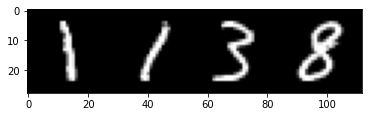

Max value: 255.0, Min value: 0.0

Reconstructions:


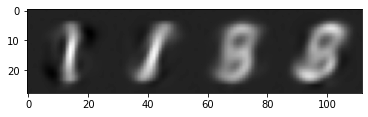

Max value: 234.02133178710938, Min value: -36.020999908447266



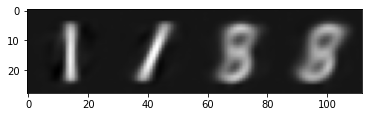

Max value: 241.76165771484375, Min value: -22.340965270996094



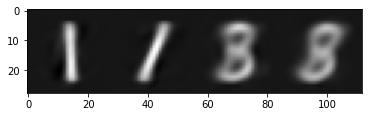

Max value: 250.7170867919922, Min value: -23.641695022583008



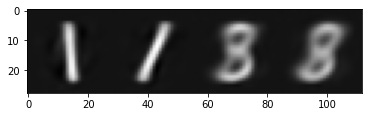

Max value: 252.6173095703125, Min value: -20.971040725708008



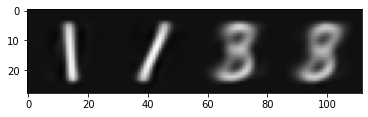

Max value: 254.6491241455078, Min value: -17.31232452392578



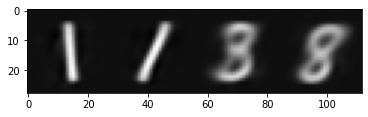

Max value: 254.91119384765625, Min value: -16.651033401489258



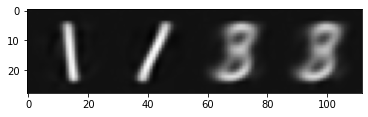

Max value: 254.26988220214844, Min value: -19.089414596557617



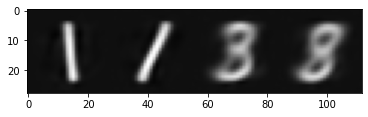

Max value: 253.590087890625, Min value: -16.63044548034668



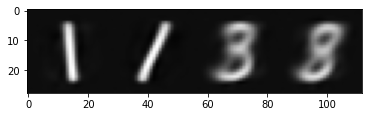

Max value: 251.3261260986328, Min value: -13.740352630615234



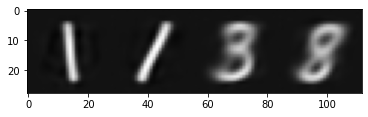

Max value: 252.65432739257812, Min value: -19.6705265045166



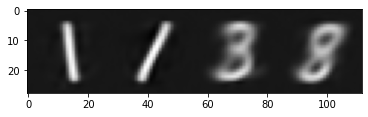

Max value: 253.922607421875, Min value: -25.0991153717041



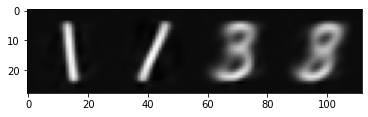

Max value: 252.00685119628906, Min value: -12.37249755859375



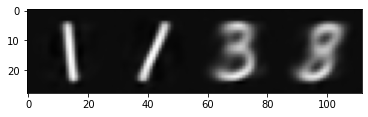

Max value: 249.3585205078125, Min value: -12.721525192260742



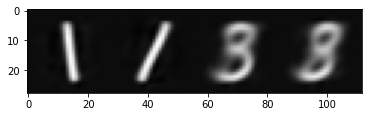

Max value: 251.14794921875, Min value: -12.450959205627441



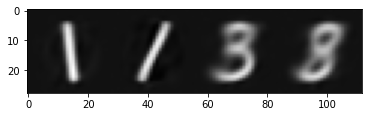

Max value: 264.2807312011719, Min value: -19.56340217590332



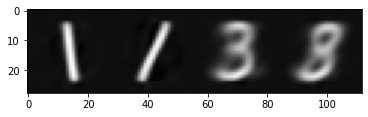

Max value: 250.37217712402344, Min value: -15.357015609741211



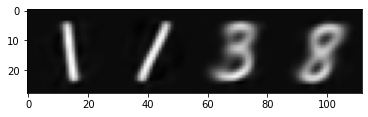

Max value: 252.81954956054688, Min value: -11.626612663269043



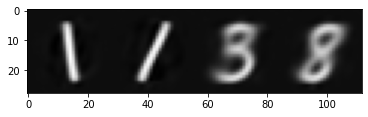

Max value: 250.1036376953125, Min value: -14.103055953979492



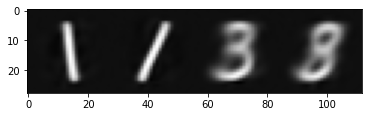

Max value: 248.83872985839844, Min value: -15.580543518066406



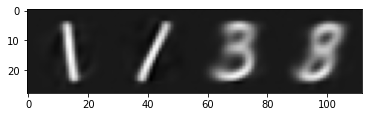

Max value: 250.23208618164062, Min value: -27.39607048034668



In [ ]:
train_loader = train_loader_mnist_8bit
val_loader = val_loader_mnist_8bit
use_sigmoid = True

lr0 = 1e-3
beta1 = 0.5
beta2 = 0.999
lr_decay = 0.97
decay_rate = 2

nEpochs = 200

zDim = 2
nSamples = 12
vae = VAE_GEGD(28*28, 500, zDim, use_sigmoid).to(device)
criterion = loss_VAE_GEGD

optimizer = torch.optim.Adam(vae.parameters(), lr0, (beta1, beta2))

print('Reference images:')
img1 = val_loader.dataset[29][0]
img2 = val_loader.dataset[202][0]
img3 = val_loader.dataset[323][0]
img4 = val_loader.dataset[110][0]
imgs = np.hstack((img1.numpy()[0], img2.numpy()[0], 
                  img3.numpy()[0], img4.numpy()[0]))
plt.figure()
plt.imshow(imgs,cmap=cm.gray)
plt.show()
print('Max value: {}, Min value: {}\n'.format(np.amax(imgs), np.amin(imgs)))


train_loss = []
val_loss = []
print('Reconstructions:')
for epoch in np.arange(1, nEpochs+1):
    ## Train loop
    vae.train()
    for batch_idx, (x_b, _) in enumerate(train_loader):
        x_b = x_b.view(-1, 28*28).to(device)
        
        mu_z, sigma_z, mu_x, sigma_x = vae(x_b, nSamples)
        
        loss = criterion(x_b, mu_z, sigma_z, mu_x, sigma_x)

        optimizer.zero_grad() ## Important to reset gradients
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        img1_ = img1.view(-1, 28*28).to(device)
        img2_ = img2.view(-1, 28*28).to(device)
        img3_ = img3.view(-1, 28*28).to(device)
        img4_ = img4.view(-1, 28*28).to(device)

        _, _, img1_, _ = vae(img1_, 1)
        _, _, img2_, _ = vae(img2_, 1)
        _, _, img3_, _ = vae(img3_, 1)
        _, _, img4_, _ = vae(img4_, 1)

        imgs = np.hstack((img1_.cpu().detach().numpy()[0].reshape(28,28), 
                          img2_.cpu().detach().numpy()[0].reshape(28,28), 
                          img3_.cpu().detach().numpy()[0].reshape(28,28), 
                          img4_.cpu().detach().numpy()[0].reshape(28,28)))
        plt.figure()
        plt.imshow(imgs,cmap=cm.gray)
        plt.show()
        print('Max value: {}, Min value: {}\n'.format(np.amax(imgs), np.amin(imgs)))

model1 = deepcopy(vae)

Reference images:


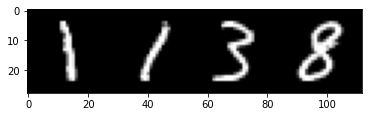

Reconstructions:


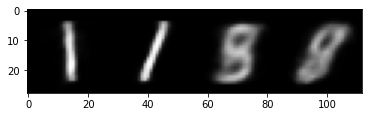

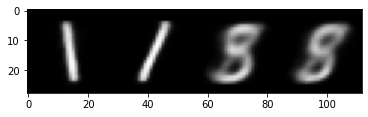

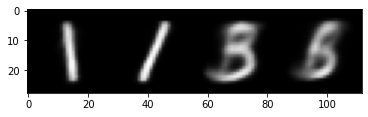

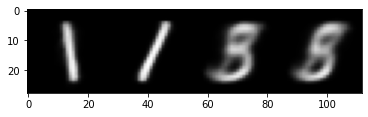

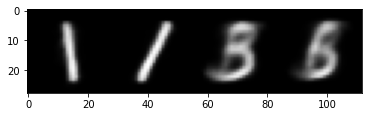

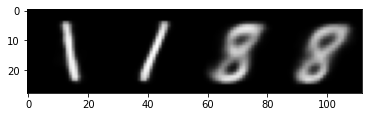

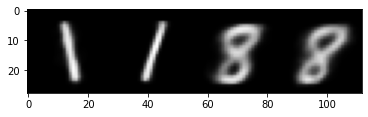

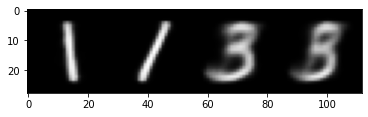

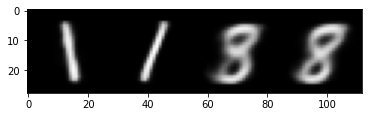

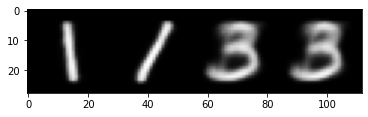

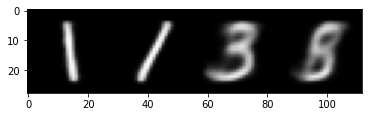

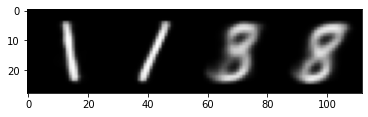

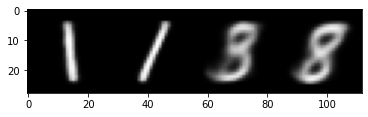

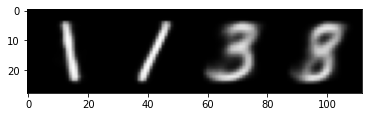

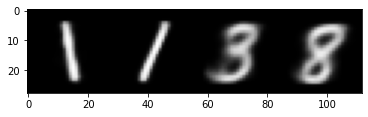

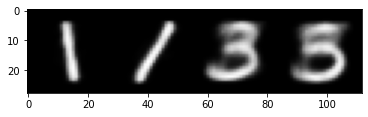

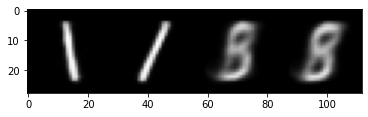

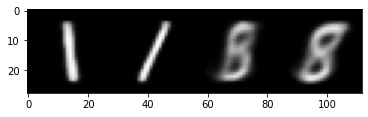

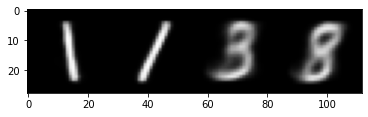

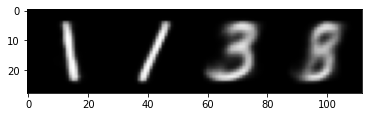

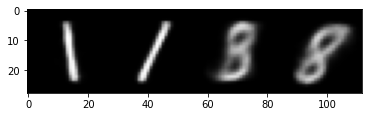

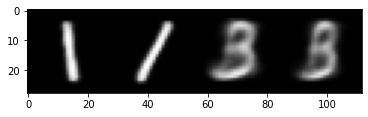

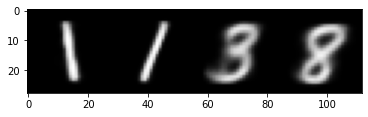

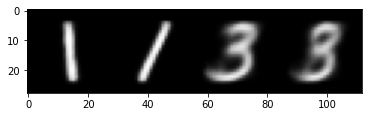

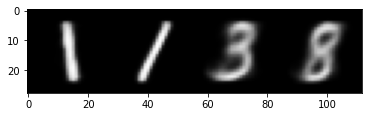

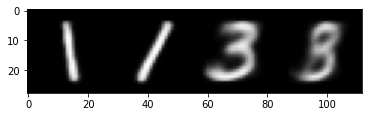

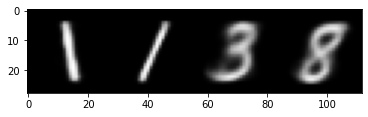

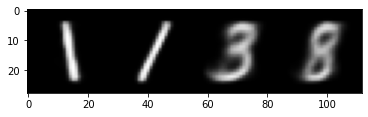

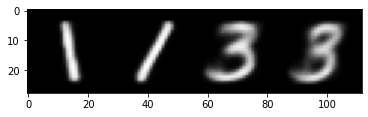

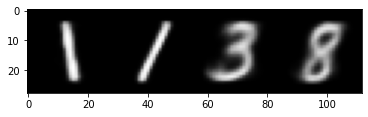

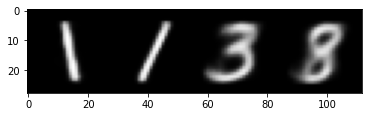

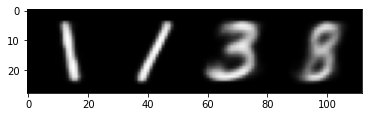

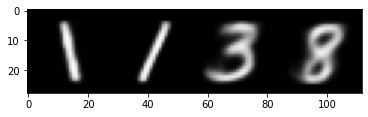

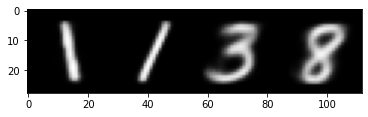

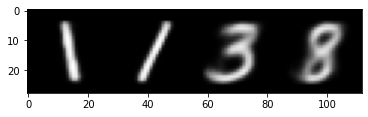

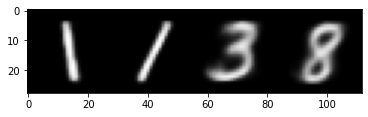

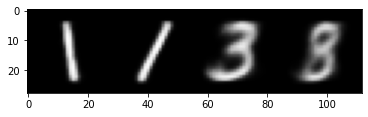

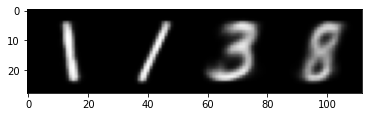

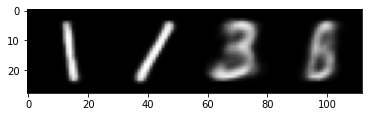

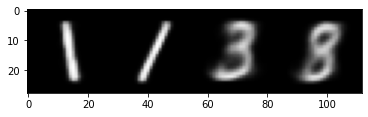

In [ ]:
train_loader = train_loader_mnist
val_loader = val_loader_mnist

lr0 = 1e-3
beta1 = 0.5
beta2 = 0.999
lr_decay = 0.97
decay_rate = 2

nEpochs = 200

zDim = 2
nSamples = 12
vae = VAE_GEBD(28*28, 500, zDim).to(device)
criterion = loss_VAE_GEBD

optimizer = torch.optim.Adam(vae.parameters(), lr0, (beta1, beta2))

print('Reference images:')
img1 = val_loader.dataset[29][0]
img2 = val_loader.dataset[202][0]
img3 = val_loader.dataset[323][0]
img4 = val_loader.dataset[110][0]
imgs = np.hstack((img1.numpy()[0], img2.numpy()[0], 
                  img3.numpy()[0], img4.numpy()[0]))
plt.figure()
plt.imshow(imgs,cmap=cm.gray)
plt.show()
# print('Max value: {}, Min value: {}\n'.format(np.amax(imgs), np.amin(imgs)))


train_loss = []
val_loss = []
print('Reconstructions:')
for epoch in np.arange(1, nEpochs+1):
    ## Train loop
    vae.train()
    for batch_idx, (x_b, _) in enumerate(train_loader):
        x_b = x_b.view(-1, 28*28).to(device)
        
        mu_z, sigma_z, y = vae(x_b, nSamples)
        
        loss = criterion(x_b, mu_z, sigma_z, y)

        optimizer.zero_grad() ## Important to reset gradients
        loss.backward()
        optimizer.step()
        
    if epoch % 5 == 0:
        img1_ = img1.view(-1, 28*28).to(device)
        img2_ = img2.view(-1, 28*28).to(device)
        img3_ = img3.view(-1, 28*28).to(device)
        img4_ = img4.view(-1, 28*28).to(device)

        _, _, img1_ = vae(img1_, 1)
        _, _, img2_ = vae(img2_, 1)
        _, _, img3_ = vae(img3_, 1)
        _, _, img4_ = vae(img4_, 1)

        imgs = np.hstack((img1_.cpu().detach().numpy()[0].reshape(28,28), 
                          img2_.cpu().detach().numpy()[0].reshape(28,28), 
                          img3_.cpu().detach().numpy()[0].reshape(28,28), 
                          img4_.cpu().detach().numpy()[0].reshape(28,28)))
        plt.figure()
        plt.imshow(imgs,cmap=cm.gray)
        plt.show()
        # print('Max value: {}, Min value: {}\n'.format(np.amax(imgs), np.amin(imgs)))

model2 = deepcopy(vae)

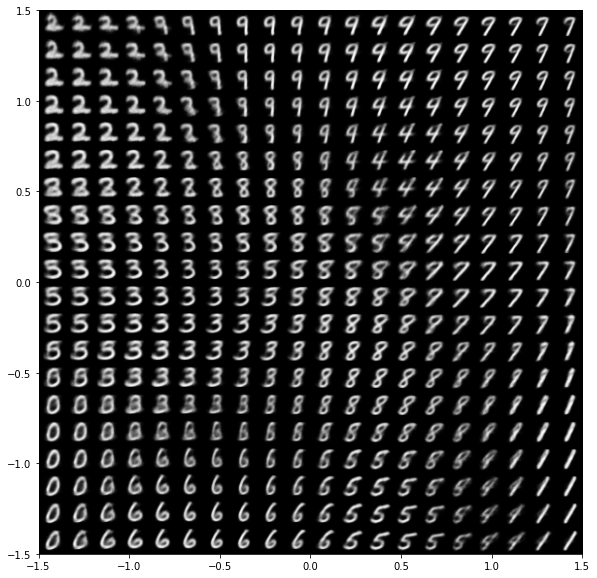

In [ ]:
model = model2.to(device)
model.eval()

## Create latent variables on a grid
z1 = torch.from_numpy(np.linspace(-1.5,1.5,20))
z2 = torch.from_numpy(np.linspace(-1.5,1.5,20))
z = torch.FloatTensor(len(z1), len(z2), 2)
for i in np.arange(z1.shape[0]):
    for j in np.arange(z2.shape[0]):
        z[i,j,0] = z1[i]
        z[i,j,1] = z2[j]
z = z.view(-1,2).to(device)

## Get images from latent variables
sampled_images = model.decoder(z).cpu().view(-1,28,28)

## Plot
images = sampled_images.detach().numpy()
image_array = np.zeros((28 * len(z1), 28 * len(z2)))
c = 0
for i in np.arange(len(z1)):
    for j in np.arange(len(z2)):
        image_array[28 * i : 28 * (i+1), 28 * j : 28 * (j+1)] = images[c]
        c += 1
fig = plt.figure(figsize=(10,10))
plt.imshow(image_array, cmap='gray', extent=[-1.5,1.5,-1.5,1.5])
plt.show()

### 2.3.- Conclusiones

En esta sección discutimos los principios básicos de los *Autoencoders* y su aproximación variacional. Evidentemente la arquitectura vista se puede modificar y sofisticar pero centremosnos en lo que hemos desarrollado hasta ahora:

* En Inferencia Variacional vimos cómo podemos aproximar la distribución de las variables latentes $\mathbf{Z}$ a partir de la variable observable $\mathbf{X}$ generada por $\mathbf{Z}$, dado un modelo de verosimilitud $p(\mathbf{x}|\mathbf{z})$ y parametrizando la familia de distribuciones sobre $\mathbf{Z}$.

* Relajamos un poco el modelo anterior al considerar que desconocemos el modelo de verosimilitud (denominado como *decoder*) y definimos el problema de encontrar tanto $p(\mathbf{z}|\mathbf{x})$ como $p(\mathbf{x}|\mathbf{z})$ como uno de inferencia variacional, donde utilizamos redes neuronales para parametrizar nuestras aproximaciones.

En ambos casos, asumimos que la variable $\mathbf{Z}$ define (o es relevante para) el comportamiento estadístico de $\mathbf{X}$ y es, por lo tanto, una representación comprimida de $\mathbf{X}$. 

Podemos entender $\mathbf{Z}$ como la información relevante para poder generar muestras del fenómeno $\mathbf{X}$. Entonces es posible hacernos las siguientes preguntas:

¿Qué pasa si nuestra tarea ya no fuera poder reconstruir $\mathbf{X}$ si no que encontrar la información que esta nos puede dar sobre otro proceso o señal $\mathbf{Y}$? ¿Es entonces $\mathbf{Z}$ **relevante** para definir o predecir $\mathbf{Y}$?

Este problema puede ser planteado formalmente por medio del *Information Bottleneck*.

## 3.- *Information Bottleneck*

Para ejemplificar la idea anterior veamos este ejemplo "clásico": 

Se desea diagnosticar a un paciente para saber si tiene o no una enfermedad, predicción dada por una variable aleatoria $\mathbf{Y}$. Para esto contamos con una batería de datos de esta persona, denotados por $\mathbf{x}$. Estos datos pueden ser su nombre, edad, datos clínicos como resultados de algún exámen reciente, historial familiar, si nació en Talca o en Rancagua, lugar de trabajo, etc.

Podemos decir que $\mathbf{x}$ caracteriza al paciente, pero claramente para la tarea que nos interesa mucha de la información contenida en $\mathbf{x}$ es irrelevante. Nos gustaría encontrar un nuevo vector de características $\mathbf{z}$ que defina en mejor manera el estado de la persona y nos entregue solo los datos importantes para poder diagnosticarla.

La tarea de encontrar esta información suele denominarse Extracción de Características, *Feature Engineering*, *Representation Learning*, etc.

En el paper fundacional del método del *Information Bottleneck* los autores se plantean precisamente este problema. A partir de la pregunta de cuál es la información relevante que una señal provee acerca de otra llegan en forma natural a un problema de codificación, en el cual capturar en un código $\mathbf{\tilde{X}}$ dicha información relevante.

Visto de esta forma, el problema se puede plantear como uno de *lossy source coding* formalizado en una rama de teoría de la información conocida como *rate-distortion theory*.

### 3.1.- *Rate-Distortion Theory*

#### 3.1.1.- Contexto

Consideremos una señal $\mathbf{X} \in \mathcal{X}$ que es nuestra variable observable y el *codebook* $\tilde{\mathcal{X}}$ donde vive la variable $\tilde{\mathbf{X}}$ que corresponde a un mapeo estocástico de $\mathbf{X}$ por medio del canal (o *encoder*) $p(\tilde{\mathbf{x}}|\mathbf{x})$.

Dado que nos enfrentamos a un problema de codificación con pérdida, el código $\tilde{\mathbf{X}}$ no es únicamente decodificable. Esta pérdida está relacionada con la cantidad de símbolos en $\mathcal{X}$ mapeados a un mismo valor en $\tilde{\mathcal{X}}$, la cual en promedio corresponde a $2^{H(\mathbf{X}|\tilde{\mathbf{X}})}$, con

\begin{equation}
  H(\mathbf{X}|\tilde{\mathbf{X}}) = -\sum_{x \in \mathcal{X}} p(x) \sum_{\tilde{x} \in \tilde{\mathcal{X}}} p(\tilde{x}|x)\log p(x|\tilde{x})
\end{equation}

Podemos interpretar entonces que $p(\tilde{\mathbf{x}}|\mathbf{x})$ induce una partición en $\mathbf{X}$, donde para cada partición asociada a $\tilde{\mathbf{X}} = \tilde{x}$ se requiere (en promedio) de $H(\mathbf{X}|\tilde{\mathbf{X}})$ bits para describir los valores de $\mathcal{X}$ asociados a dicha partición.

Luego, la variable $\mathbf{X}|\tilde{\mathbf{X}}$ requiere en promedio $H(\mathbf{X}) - H(\mathbf{X}|\tilde{\mathbf{X}}) = I(\mathbf{X};\tilde{\mathbf{X}})$ bits para ser descrita.

En este contexto, $I(\mathbf{X};\tilde{\mathbf{X}})$ cuantifica la "calidad" de la partición, pues caracteriza la cantidad de información que $\tilde{\mathbf{X}}$ posee acerca de $\mathbf{X}$ y se denomina como la **tasa de información**.

#### 3.1.2.- Formalización del Problema

Para evitar esta situación, en *rate-distortion theory* se introduce el concepto de distorsión, dada por la función $d: \mathcal{X} \times \tilde{\mathcal{X}} \to \mathbb{R}^{+} \cup \{0\}$. Dada una partición inducida por $p(\tilde{\mathbf{x}}|\mathbf{x})$ se tendrá una distorsión esperada:

\begin{equation}
  \mathbb{E}_{p(\mathbf{x},\tilde{\mathbf{x}})}\left\{d(x,\tilde{x})\right\} = \sum_{x  \in \mathcal{X}} \sum_{\tilde{x} \in \tilde{\mathcal{X}}}p(x,\tilde{x})d(x,\tilde{x})
\end{equation}

Luego, al limitar la distorsión esperada inducida por el *encoder* a un máximo, $D$, se tiene una formulación mucho más interesante del problema, planteado ahora por medio de la función $R(D)$ correspondiente a la tasa de información mínima asociada a la pérdida $D$:

\begin{equation}
R(D) = \underset{\left\{p(\tilde{\mathbf{x}}|\mathbf{x}): \mathbb{E}_{p(\mathbf{x},\tilde{\mathbf{x}})}\left\{d(x,\tilde{x})\right\} \leq D\right\}}{\operatorname{min}} I(\mathbf{X};\tilde{\mathbf{X}})
\end{equation}

Lo anterior es equivalente a minimizar el funcional:

\begin{equation}
  \mathcal{F}(p(\tilde{\mathbf{x}}|\mathbf{x})) = \underset{\sum p(\tilde{\mathbf{x}}|\mathbf{x}) = 1}{\operatorname{min}} I(\mathbf{X};\tilde{\mathbf{X}}) + \beta \mathbb{E}_{p(\mathbf{x},\tilde{\mathbf{x}})}\left\{d(x,\tilde{x})\right\}
\end{equation}

### 3.2.- Extensión

Introducimos ahora la variable en base a la cual definir la **información relevante** contenida en $\mathbf{X}$, $\mathbf{Y}$. Es en consecuencia esta variable la que define el valor de la medida de distorsión $d$.

En forma similar a como interpretamos que $I(\mathbf{X};\tilde{\mathbf{X}})$ corresponde a la información que $\tilde{\mathbf{X}}$ contiene de la variable $\mathbf{X}$, $I(\mathbf{Y};\tilde{\mathbf{X}})$ corresponde a la información contenida acerca de la variable para la cual queremos extraer la información relevante.

Un supuesto importante de este problema es que la codificación $\tilde{\mathbf{X}}$ debe satisfacer la siguiente cadena de Markov:

\begin{equation}
  \tilde{\mathbf{X}} - \mathbf{X} - \mathbf{Y}
\end{equation}

> **Nota**: Recordar que esta propiedad se traduce en la independencia condicional entre $\tilde{\mathbf{X}}$ y $\mathbf{Y}$ dado $\mathbf{X}$

Esto es puesto que las estadísticas de $\tilde{\mathbf{X}}$ están sujetas únicamente a la variable de observación. Finalmente, el mapeo $p(\tilde{\mathbf{x}}|\mathbf{x})$ óptimo se obtiene al resolver el problema de optimización 

\begin{equation}
  \underset{\sum p(\tilde{\mathbf{x}}|\mathbf{x}) = 1}{\operatorname{min}} I(\mathbf{X};\tilde{\mathbf{X}}) - \beta I(\mathbf{Y};\tilde{\mathbf{X}})
\end{equation}

Los sumandos de este problema de optimización son claramente objtetivos contrapuestos debido a la *data processing inequality* y la relación estadística entre $\mathbf{X}$ y $\tilde{\mathbf{X}}$:

Dadas las variables aleatorias $\mathbf{X}$, $\mathbf{Y}$ y $\mathbf{Z}$ tales que se tiene la cadena de Markov $\mathbf{Z} - \mathbf{X} - \mathbf{Y}$, se tendrá entonces que
\begin{equation}
  I(\mathbf{Y};\mathbf{Z}) \leq I(\mathbf{Y};\mathbf{X})
\end{equation}

dándose la igualdad estricta cuando $I(\mathbf{Y};\mathbf{X}|\mathbf{Z}) = 0$

El problema original de *rate-distortion theory* posee una solución cerrada para variables discretas y es posible encontrarla por medio del algoritmo de Blahut-Arimoto. Este resultado es extendible al problema del *Information Bottleneck* bajo la condición de Markovianidad.

Extender este problema a variables aleatorias en un espacio contínuo no es trivial y es un problema aún abierto, en general. Una forma de abordar este problema es por medio de redes neuronales lo cual revisaremos en la **Tarea**, gracias a los contenidos de las secciones anteriores sobre inferencia variacional.